In [1]:
import numpy as np
from numba import njit,jit
import matplotlib.pyplot as plt
from tqdm import tqdm

# 设定参数

## 基本参数

In [2]:
num_electron = 10**(5)
num_Hg = 20
num_voltage = 500
max_voltage = 80
lambda_Ek = 1.5
negative_voltage = 4

# 设定常量

In [3]:
e = 1.6021892*10**(-19)
kB = 1.380649*10**(-23)

## 激发常量

In [4]:
E_state = np.array([4.67,4.89,5.46])
p1 = 0.5
p2 = 0.6
p3 = 0.7

In [5]:
p01 = 0.4
p02 = 0.4
excite_2 = np.array([p01,p1+p01,p2+p1+p01])/(p01+p1+p2)
excite_3 = np.array([p02,p1+p02,p3+p1+p02,p3+p3+p1+p02])/(p02+p1+p3+p3)

# 初始化参数

## 初始化动能

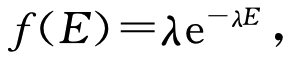

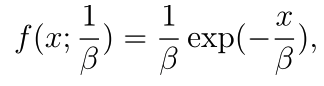

In [6]:
Ek = np.random.exponential(1/lambda_Ek,(num_voltage,num_electron))

## 生成Hg原子相对位置

In [7]:
Hg_pos = np.random.uniform(0,1,num_Hg)
Hg_pos = np.sort(Hg_pos)

## 确定每级加速能量

In [8]:
voltage = np.arange(0,max_voltage,max_voltage/num_voltage)
accelerate_tem = np.concatenate([Hg_pos,np.array([1])])-np.concatenate([np.array([0]),Hg_pos])

In [9]:
accelerate_start = accelerate_tem[0]
E_start = accelerate_start*voltage[...,None]

accelerate_arr = accelerate_tem[1:]
E_accelerate = accelerate_arr[...,None]*voltage

# 核心函数

## 确定所处位置

In [10]:
@njit
def locate(x,arr):
    return np.sum(np.expand_dims(x,axis = -1)-arr>0,axis = -1)

## 激发

In [11]:
@njit
def my_and(tup):
    return np.sum(np.stack(tup,axis = -1),axis = -1)==2

In [12]:
def excite(Ek,E_state,p1,excite_2,excite_3):
    delta_E = np.zeros(Ek.shape) # 能量差
    p = np.random.uniform(0,1,Ek.shape) # 概率
    pos = locate(Ek,E_state) # 定位
    
    # 第一激发态
    delta_E[my_and((pos==1,p<p1))] = E_state[0]
    
    # 第二激发态
    pos_2 = locate(p,excite_2)
    delta_E[my_and((pos==2,pos_2==1))] = E_state[0]
    delta_E[my_and((pos==2,pos_2==2))] = E_state[1]
    
    
    # 第三激发态
    pos_3 = locate(p,excite_3)
    delta_E[my_and((pos==3,pos_3==1))] = E_state[0]
    delta_E[my_and((pos==3,pos_3==2))] = E_state[1]
    delta_E[my_and((pos==3,pos_3==3))] = E_state[2]
    
    
    
    return Ek - delta_E

# 通过管道

In [13]:
Ek += E_start

In [14]:
for i in tqdm(range(num_Hg)):
    Ek = excite(Ek,E_state,p1,excite_2,excite_3)
    Ek += E_accelerate[i][...,None]   

100%|██████████| 20/20 [02:09<00:00,  6.47s/it]


# 被吸收

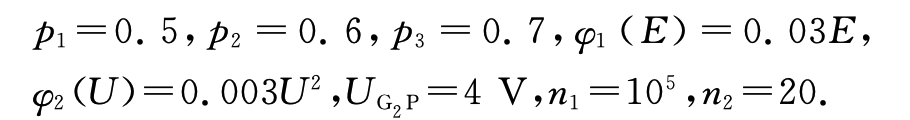

In [15]:
possibility = np.exp(-0.03*Ek-0.003*(negative_voltage**2))
p = np.random.uniform(0,1,Ek.shape)

In [16]:
Ek[p<possibility] = -np.inf

# 通过反向电压

In [17]:
Ek -= negative_voltage

In [18]:
I = np.sum(Ek>0,axis=-1)/num_electron

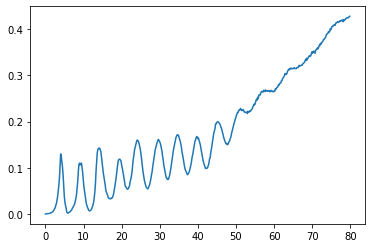

In [19]:
plt.plot(voltage,I)
plt.show()